In [1]:
from allosaurus.app import read_recognizer
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import statistics
import re

c:\Users\dorre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#list1: list of expected symbols
#list2: list of output symbols (output of allosaurus)
#conf: list of confidence for output symbols (output of allosaurus when k>=2)
def levenshteinDistance(list1, list2, conf = None):
    m = len(list1)
    n = len(list2)
    d = [[i] for i in range(1, m + 1)]   # d matrix rows
    d.insert(0, list(range(0, n + 1)))   # d matrix columns
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if list1[i - 1] == list2[j - 1]: #Python compares strings and characters the same way => each list element can be a single character or a string (word)
                substitutionCost = 0
            else:
                if conf is None:
                    substitutionCost = 1
                else:
                    substitutionCost = conf[j-1]
            if conf is None:
                d[i].insert(j, min(d[i - 1][j] + 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + 1,                         #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + substitutionCost))     #substitution
            else: 
                d[i].insert(j, min(d[i - 1][j] + 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + conf[j-1],                 #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + substitutionCost))     #substitution
    return d[-1][-1]

In [12]:
l1 = ['r', 'o', 'b', 'a', 't']
l2 = ['r', 'b', 'a', 'k', 't']
co = [1,    2,   3,   4,   5]
dist = levenshteinDistance(l1, l2, co)
dist

5

In [7]:
#path of the audio file folder which should contain the text and wave files
#which are explained in the allosaurus fine-tune instructions.
parent_test_path = '.\\FARSDAT-parent-c100\\validate' 

test_text = parent_test_path + '\\text'
symbols = []
file_names = []
with open(test_text, encoding='utf-8') as file:
    for line in file:
        res = line.rstrip().split(' ')
        symbols.append(res[1:])

test_wave = parent_test_path + '\\wave'
with open(test_wave, encoding='utf-8') as file:
    for line in file:
        res = line.rstrip().split(' ')
        file_names.append(res[1])

In [17]:
#get leveneshtein distance for input files using the input model and k=2
#in order to obtain the confidence for each produced phone in the output.
def get_levdist_with_k(model_name, filenames, actual_symbols):
    #path of the folder for the files containg the result (weighted lev distance for input audio files)
    levdis_files_path = '.\\output-files\\levdis-files-with-k'

    recognizer = read_recognizer(model_name)

    #make output file which will contain the results
    output_fd = open(os.path.join(levdis_files_path, model_name + '-validate'), 'w', encoding='utf-8') 

    all_perc_values = []

    for i in range(len(filenames)):
        rec_out = recognizer.recognize(filenames[i], lang_id="pes", topk=2)
        if rec_out is None:
            continue
        #an example of an output (rec_out): 'r (0.871) l (0.121) | m (0.771) n (0.031) | ...'
        rec_out = rec_out.rstrip().split() #split on spaces

        #only the top phone is needed so for the above example we need 'r', 'm', ...
        phones = rec_out[::5]
        
        #only the top confidence is needed so for the above example we need '(0.871)', '(0.771)', ...
        #but we need the float numbers and not the strings so parentheses should be removed first and then the number be converted to float
        confidence = [float(re.sub(r'[()]', '', val)) for key,val in enumerate(rec_out) if key % 5 == 1] 

        dist = levenshteinDistance(actual_symbols[i], phones, confidence) #weighted lev distance
        perc = (len(actual_symbols[i])-dist)/len(actual_symbols[i]) #percision ()

        output_fd.write(filenames[i] + ' ' + str(dist) + ' ' + str(perc) + '\n')

    output_fd.close()


In [18]:
get_levdist_with_k('uni2005', file_names, symbols)
print('uni2005 done')

get_levdist_with_k('8s100p20', file_names, symbols)
print('8s100p20 done')

get_levdist_with_k('8s100p20allrb30', file_names, symbols)
print('8s100p20allrb30 done')

uni2005 done
8s100p20 done
8s100p20allrb30 done


In [3]:
#use files to evaluate the model
def get_levdist(model_name, filenames, actual_symbols):
    levdis_files_path = '.\\output-files\\levdis-files6'
    

    recognizer = read_recognizer(model_name)

    #output file for writing the results
    output_fd = open(os.path.join(levdis_files_path, model_name + '-train'), 'w', encoding='utf-8') 

    all_perc_values = []

    for i in range(len(filenames)):
        phones = recognizer.recognize(filenames[i], lang_id="pes")
        if phones is None:
            continue
        phones = phones.rstrip().split()
        dist = levenshteinDistance(actual_symbols[i], phones)
        perc = (len(actual_symbols[i])-dist)/len(actual_symbols[i])
        output_fd.write(filenames[i] + ' ' + str(dist) + ' ' + str(perc) + '\n')
    output_fd.close()


In [ ]:
get_levdist('8s100p20allrb', file_names)
print('8s100p20allrb done')

# eval_model('8s50p7')
# print('8s50p7 done')
# eval_model('8s50p10')
# print('8s50p10 done')
# eval_model('8s50p12')
# print('8s50p12 done')
# eval_model('8s50p14')
# print('8s50p14 done')
# eval_model('8s50p16')
# print('8s50p16 done')
# eval_model('8s50p18')
# print('8s50p18 done')
# eval_model('8s50p20')
# print('8s50p20 done')

In [10]:
input_files = []
for root_dir, cur_dir, files in os.walk(r'.\\output-files\\levdis-files6'):
    for fname in files:
        input_files.append(os.path.join('output-files\\levdis-files6', fname))

In [4]:
def draw_perc(in_files, spl_word, title):
    i = 0
    # fig , ax = plt.subplots(1, 1, figsize = (20, 50))
    plt.rcParams["figure.figsize"] = (15,5)
    all_percs = []
    for i in range(len(in_files)):
        with open(in_files[i], encoding='utf-8') as file:
            percs = []
            for line in file:
                res = line.rstrip().split(' ')
                percs.append(float(res[2]))

            all_percs.append(statistics.fmean(percs))

            # ax[i].title.set_text(title)
            
            # ax[i].set_ylim(ylim)
            # print('mean percision of' + in_files[i] + ' is:' + str(statistics.fmean(percs)))
            i += 1
    
    epoch_numbers = [re.findall(r'\d+', val) for key,val in enumerate(in_files,1)]
    epoch_numbers = [int(col[3]) for col in epoch_numbers]   
    plt.plot(epoch_numbers,all_percs)
    plt.xticks(range(epoch_numbers[0] , epoch_numbers[len(epoch_numbers)-1]+1), range(epoch_numbers[0] , epoch_numbers[len(epoch_numbers)-1]+1))
    # plt.xticks(range(len(in_files)), in_files)
    plt.xlabel('Epoch')
    plt.ylabel('Percision')
    plt.title(title)  
    plt.grid()     
    plt.show()

In [47]:
print(input_files)
print(len(input_files))

['levdis-files3\\8s100p07-tests', 'levdis-files3\\8s100p10-tests', 'levdis-files3\\8s100p12-tests', 'levdis-files3\\8s100p14-tests', 'levdis-files3\\8s100p16-tests', 'levdis-files3\\8s100p18-tests', 'levdis-files3\\8s100p20-tests', 'levdis-files3\\8s10p01-tests', 'levdis-files3\\8s10p02-tests', 'levdis-files3\\8s10p03-tests', 'levdis-files3\\8s10p04-tests', 'levdis-files3\\8s10p05-tests', 'levdis-files3\\8s10p06-tests', 'levdis-files3\\8s10p07-tests', 'levdis-files3\\8s10p08-tests', 'levdis-files3\\8s10p09-tests', 'levdis-files3\\8s10p10-tests', 'levdis-files3\\8s10p11-tests', 'levdis-files3\\8s10p12-tests', 'levdis-files3\\8s10p13-tests', 'levdis-files3\\8s10p14-tests', 'levdis-files3\\8s10p15-tests', 'levdis-files3\\8s10p16-tests', 'levdis-files3\\8s10p17-tests', 'levdis-files3\\8s10p18-tests', 'levdis-files3\\8s10p19-tests', 'levdis-files3\\8s10p20-tests', 'levdis-files3\\8s10p21-tests', 'levdis-files3\\8s10p22-tests', 'levdis-files3\\8s10p23-tests', 'levdis-files3\\8s10p24-tests', 

In [ ]:
spl_word = '.wav '
# print(input_files[1:26])
draw_perc(input_files[1:26],spl_word, "Percision - Epoch for models trained on 10% of the train files")

In [ ]:
spl_word = '.wav '
# print(input_files[26:51])
draw_perc(input_files[26:51],spl_word, "Percision - Epoch for models trained on 20% of the train files")

In [ ]:
spl_word = '.wav '
print(input_files[64:65] + input_files[0:7])
draw_perc(input_files[64:65] + input_files[0:7],spl_word, "Percision - Epoch for models trained on 100% of the train files")

In [ ]:
spl_word = '.wav '
print(input_files[0:7])
draw_perc(input_files[0:7],spl_word, "Percision - Epoch for models trained on 100% of the train files")

In [ ]:
spl_word = '.wav '
print(input_files[64:65] + input_files[57:64])
draw_perc(input_files[64:65] + input_files[57:64],spl_word, "Percision - Epoch for models trained on 50% of the train files")

In [ ]:
spl_word = '.wav '
print(input_files[57:64])
draw_perc(input_files[57:64],spl_word, "Percision - Epoch for models trained on 50% of the train files")

In [5]:
t_list1 = ['r', 'o', 'b', 'ɒ', 'tʰ', 'e', 'b', 'e', 'h', 'e', 'ʃ', 'tʰ', 'i']
t_list2 = ['r̪', 'o̞', 'b', 'ɒː', 't̠', 'e̞', 'b', 'e̞', 'h', 'e̞', 'ʃ', 't̠', 'i']
t_list3 = ['r̪', 'o̞', 'b', 'ɒː', 't̪ʰ', 'e', 'b', 'e', 'h', 'e', 'ʃʰ', 't̪ʰ', 'iː']

def levenshteinDistanceForBadUni(list1):
    m = len(list1)
    n = len(t_list1)
    d = [[i] for i in range(1, m + 1)]   # d matrix rows
    d.insert(0, list(range(0, n + 1)))   # d matrix columns
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if list1[i - 1] == t_list1[j - 1] or list1[i - 1] == t_list2[j - 1] or list1[i - 1] == t_list3[j - 1]:
                substitutionCost = 0
            else:
                substitutionCost = 1
            d[i].insert(j, min(d[i - 1][j] + 1,
                               d[i][j - 1] + 1,
                               d[i - 1][j - 1] + substitutionCost))
    return d[-1][-1]

In [7]:
target_phone_list = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']

def eval_model(filenames, model_name, ext_name):
    levdis_files_path = '.\\output-files\\levdis-files-allrb20-robatbeheshti'
    recognizer = read_recognizer(model_name)

    #output file for writing the results
    output_fd = open(os.path.join(levdis_files_path, model_name + ext_name), 'w', encoding='utf-8') 

    all_perc_values = []

    for i in range(len(filenames)):
        phones = recognizer.recognize(filenames[i], lang_id="pes")
        if phones is None:
            continue
        phones = phones.rstrip().split()
        dist = levenshteinDistance(target_phone_list, phones)
        # dist = levenshteinDistanceForBadUni(phones)
        output_fd.write(filenames[i] + ' ' + str(dist) + '\n')
    output_fd.close()


In [16]:
parent_test_path = '.\\validation-ntns' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
eval_model(f1, 'allrb20', '-ntns')
print('ntns done')


parent_test_path = '.\\validation-nts' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
eval_model(f1, 'allrb20', '-nts')
print('nts done')

parent_test_path = '.\\validation-target' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
eval_model(f1, 'allrb20', '-target')
print('target done')

ntns done
nts done
target done


In [10]:
def draw_hist(in_file, xlim, ylim, title):

    fig , ax = plt.subplots(1, 1, figsize = (20, 10))

    with open(in_file, encoding='utf-8') as file:
        dists = []
        for line in file:
            res = line.rstrip().split(' ')
            dists.append(int(res[1]))
        dists.sort()
        
        ax.title.set_text(title)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.hist(dists, bins = dists)   
         
        plt.show()

In [17]:
input_files = []
for root_dir, cur_dir, files in os.walk(r'.\\levdis-files-allrb20-robatbeheshti'):
    for fname in files:
        input_files.append(os.path.join('levdis-files-allrb20-robatbeheshti', fname))
input_files

['levdis-files-allrb20-robatbeheshti\\allrb20-ntns',
 'levdis-files-allrb20-robatbeheshti\\allrb20-nts',
 'levdis-files-allrb20-robatbeheshti\\allrb20-target']

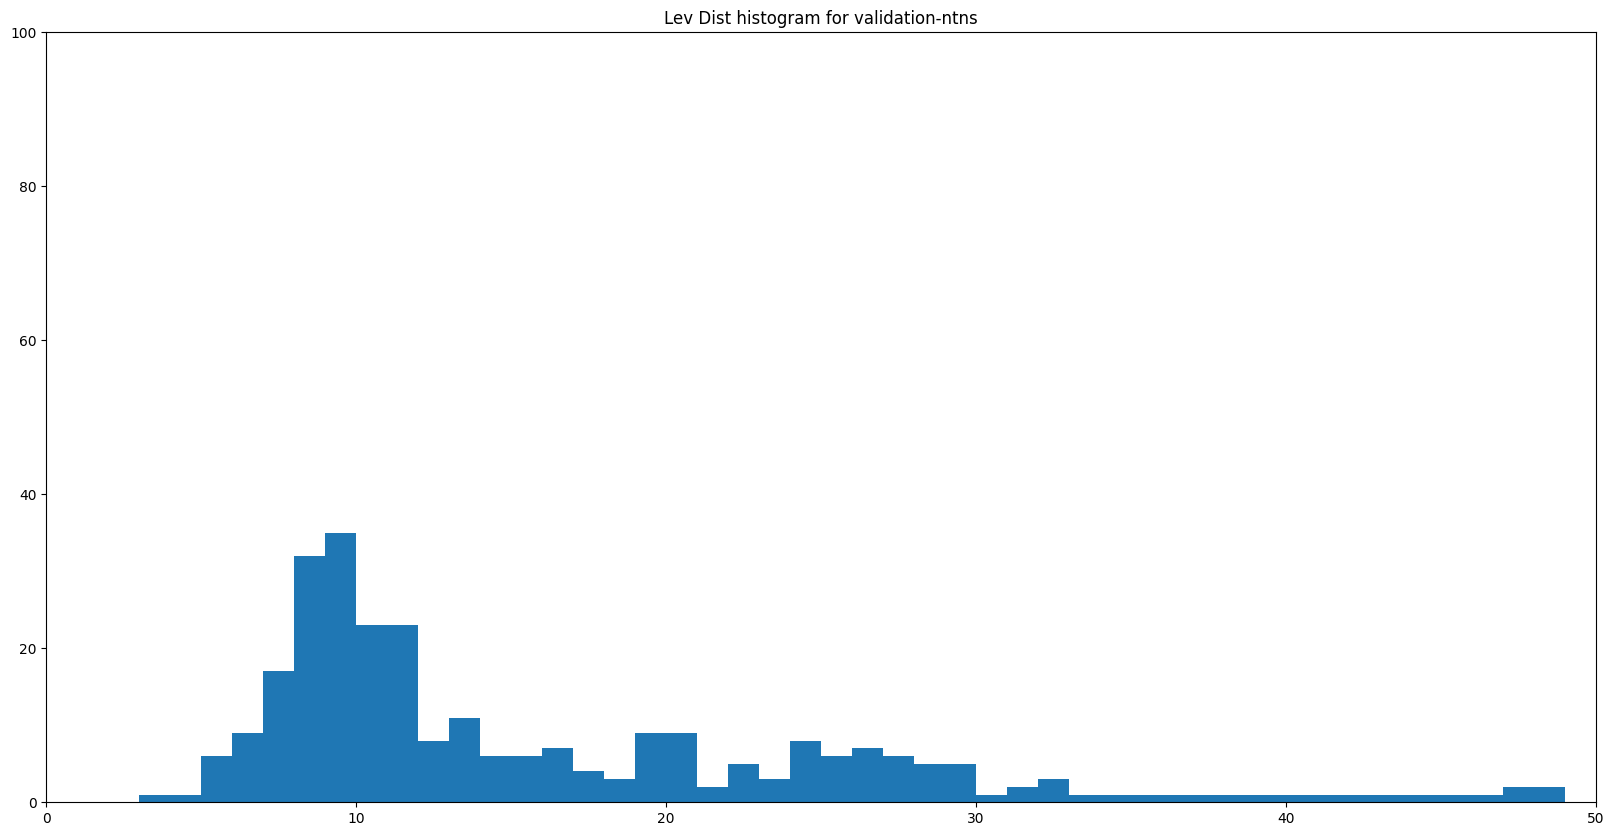

In [18]:
xlim = [0,50]
ylim = [0,100]

draw_hist(input_files[0],spl_word, xlim, ylim, "Lev Dist histogram for validation-ntns")


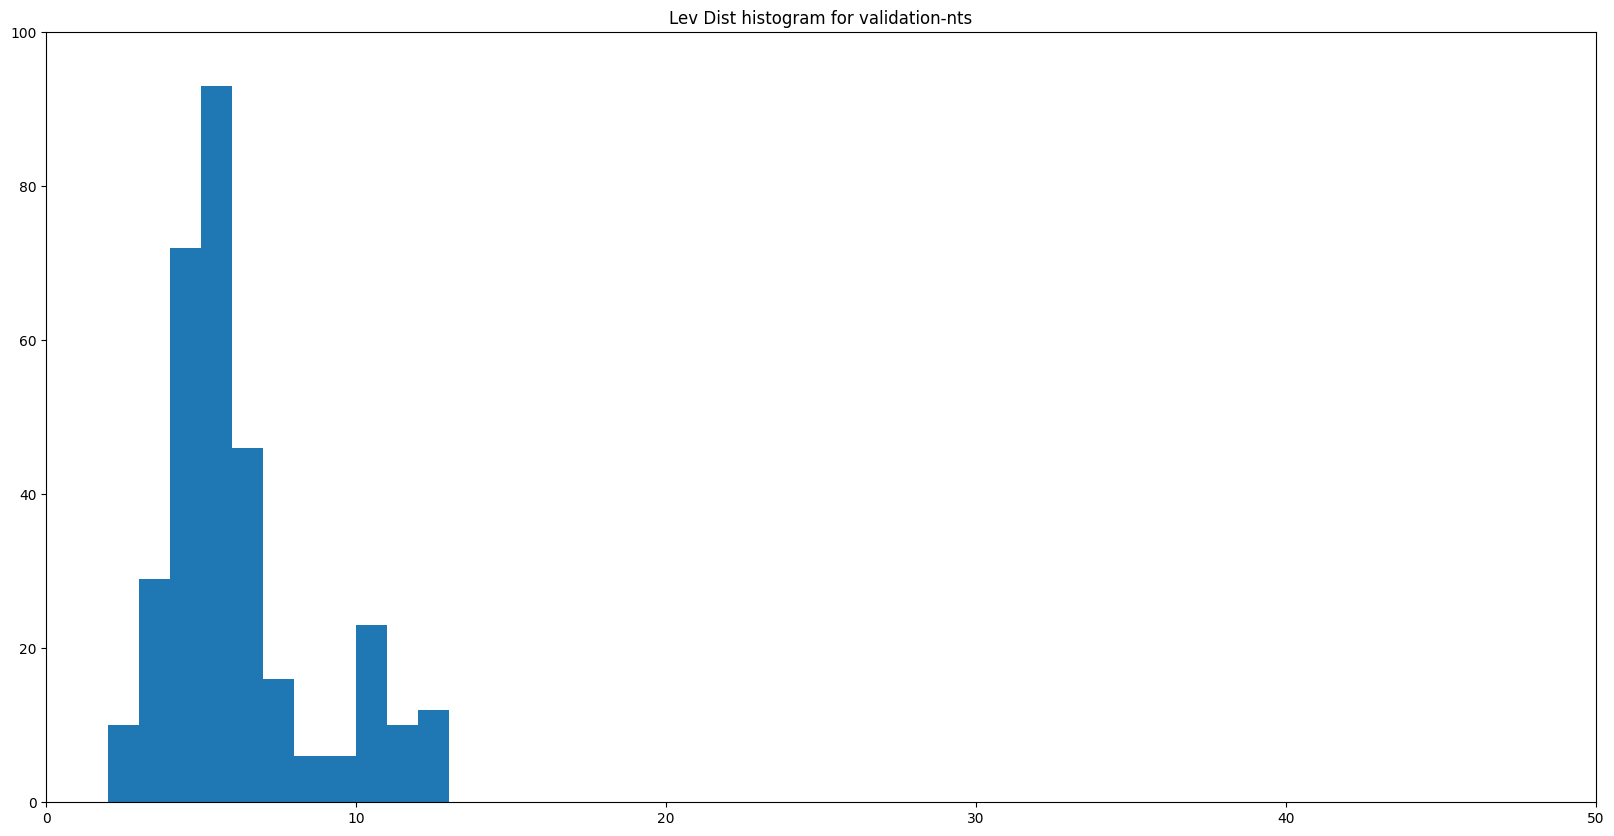

In [19]:
xlim = [0,50]
ylim = [0,100]

draw_hist(input_files[1],spl_word, xlim, ylim, "Lev Dist histogram for validation-nts")

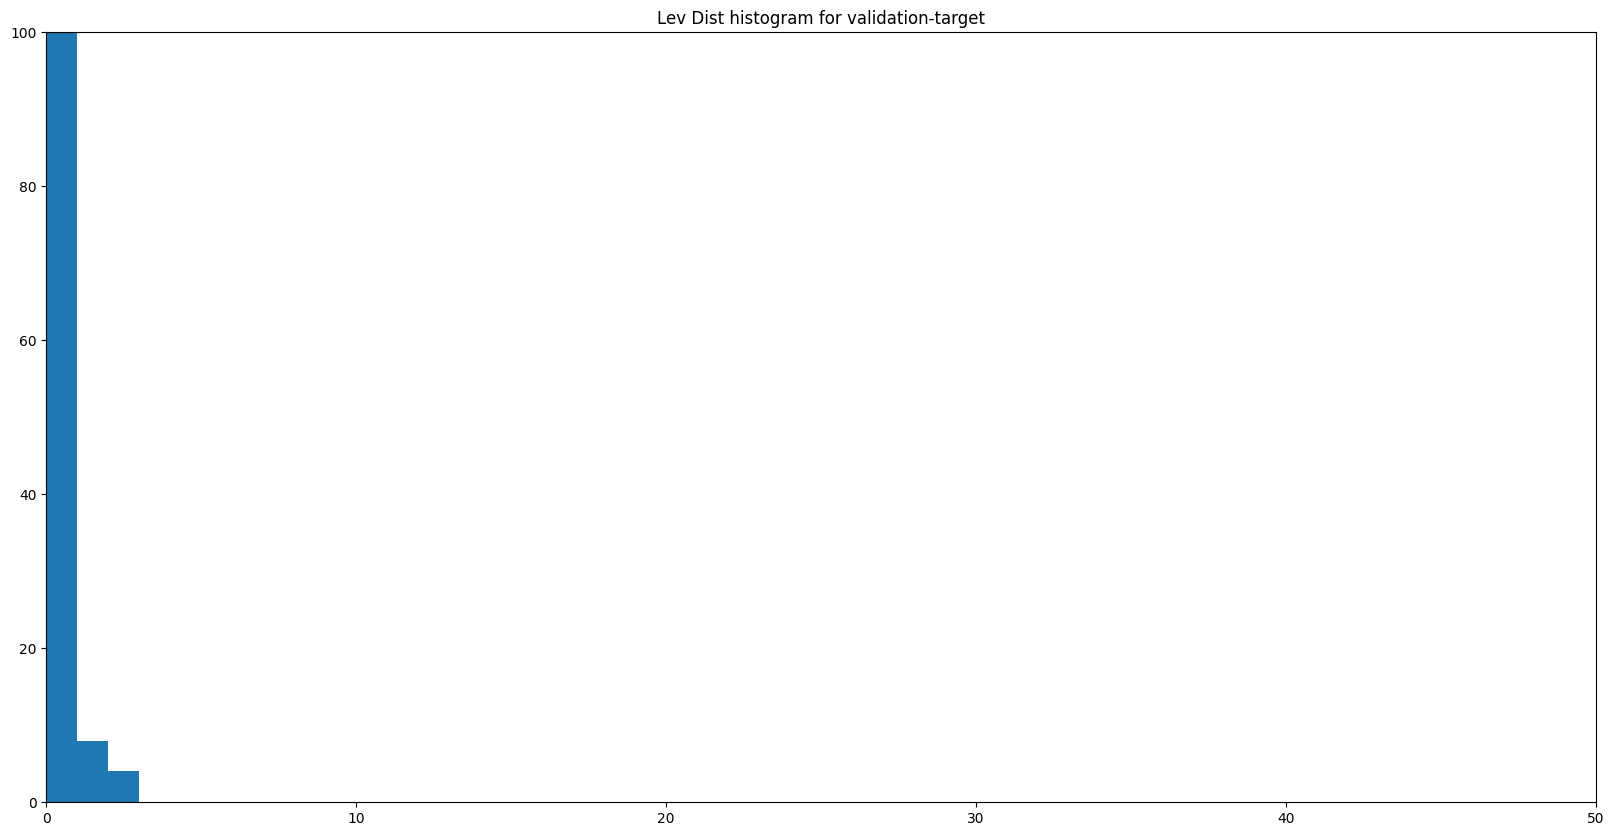

In [20]:
xlim = [0,50]
ylim = [0,100]

draw_hist(input_files[2],spl_word, xlim, ylim, "Lev Dist histogram for validation-target")


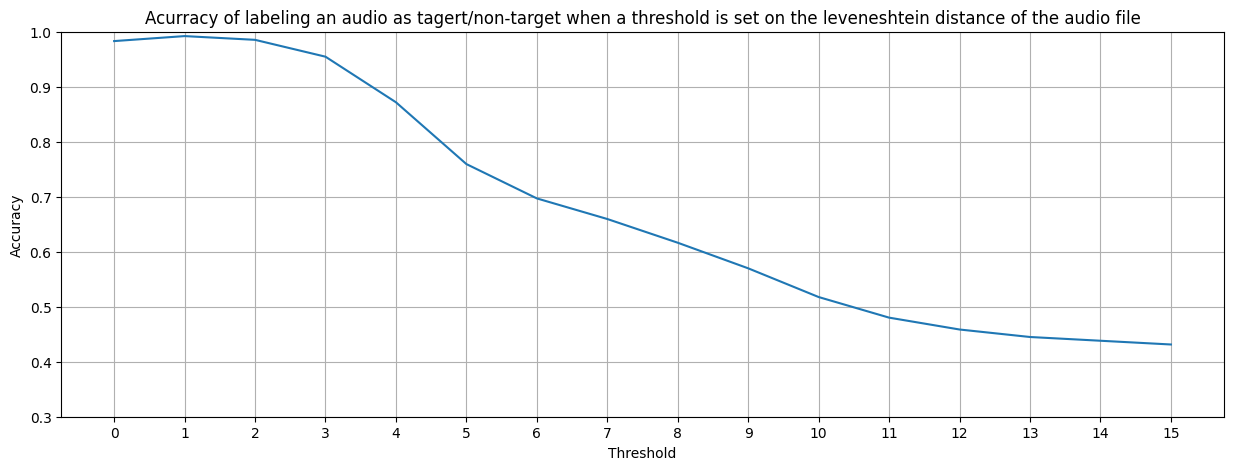

accuracy at 1:  0.9920544835414302
accuracy at 2:  0.985244040862656


In [21]:
spl_word = '.wav '
total_file = 0
acc = []
val1 = []
val2 = []
val3 = []
thresh_range = range(0,16)
with open(input_files[0], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        val1.append(int(res[1]))
with open(input_files[1], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        val2.append(int(res[1]))
with open(input_files[2], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        val3.append(int(res[1]))
     
for thresh in thresh_range:
    correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
    # print("{0}, {1}, {2}".format(sum(i < thresh for i in val1) , sum(i > thresh for i in val2) , sum(i > thresh for i in val3)))
    acc.append(correct/total_file)


plt.rcParams["figure.figsize"] = (15,5)
plt.plot(thresh_range,acc)
plt.xticks(thresh_range, thresh_range)
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Acurracy of labeling an audio as tagert/non-target when a threshold is set on the leveneshtein distance of the audio file')
plt.grid()   
plt.ylim([0.30, 1.0])  
plt.show()

print("accuracy at 1: ", acc[1])
print("accuracy at 2: ", acc[2])

In [ ]:
with open(input_files[0], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        if int(res[1]) <= 7:
            print(res[0])
with open(input_files[1], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        if int(res[1]) <= 7:
            print(res[0])